In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
df = sm.datasets.get_rdataset('deaths', 'MASS').data
df.head()

,time,value
0,1974.000000,3035
1,1974.083333,2552
2,1974.166667,2704
3,1974.250000,2554
4,1974.333333,2014


In [3]:
mpl.rcParams['axes.unicode_minus']
mpl.rc('font', family='D2Coding')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

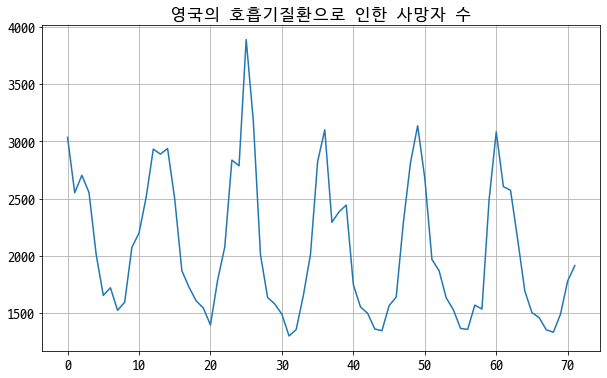

In [4]:
df.value.plot()
plt.title("영국의 호흡기질환으로 인한 사망자 수")
plt.grid()
plt.show()

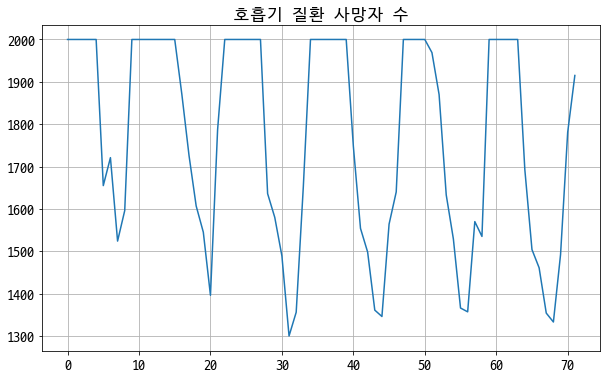

In [6]:
df['cliped_value'] = df.value.clip(upper=2000)
df.cliped_value.plot()
plt.title('호흡기 질환 사망자 수')
plt.grid()
plt.show()

In [7]:
model_ARMA = sm.tsa.ARMA(df['cliped_value'], (1, 2))
result_ARMA = model_ARMA.fit()
print(result_ARMA.summary())

                              ARMA Model Results                              
Dep. Variable:           cliped_value   No. Observations:                   72
Model:                     ARMA(1, 2)   Log Likelihood                -460.457
Method:                       css-mle   S.D. of innovations            143.769
Date:                Thu, 09 Jul 2020   AIC                            930.915
Time:                        14:25:05   BIC                            942.298
Sample:                             0   HQIC                           935.447
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1782.0540     64.335     27.700      0.000    1655.960    1908.148
ar.L1.cliped_value     0.5829      0.130      4.496      0.000       0.329       0.837
ma.L1.cliped_value  

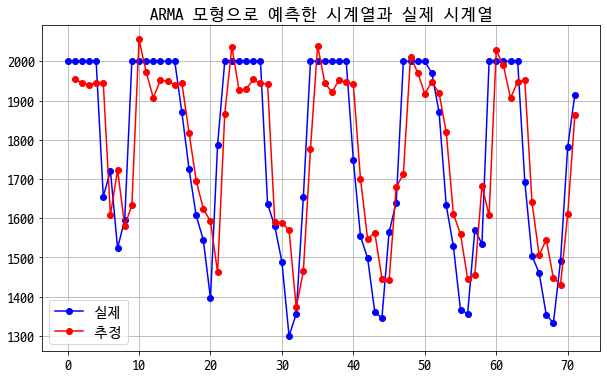

In [8]:
plt.plot(df["cliped_value"], "bo-", label="실제")
plt.plot(result_ARMA.predict(1), "ro-", label="추정")
plt.title('ARMA 모형으로 예측한 시계열과 실제 시계열')
plt.legend()
plt.grid()
plt.show()

In [9]:
time_step = 7

df['cliped_std_value'] = df.cliped_value.map(lambda x: (x - df.cliped_value.mean()) / np.std(df.cliped_value))

x_train = np.asarray([np.array([df.cliped_std_value[i+j] for j in range(time_step)])
                     for i in range(len(df.cliped_std_value) - time_step)]).reshape(-1, time_step, 1)

In [10]:
y_train = df.cliped_std_value.values[time_step:]
x_train.shape, y_train.shape

((65, 7, 1), (65,))

In [11]:
df.head()

,time,value,cliped_value,cliped_std_value
0,1974.000000,3035,2000,0.93284
1,1974.083333,2552,2000,0.93284
2,1974.166667,2704,2000,0.93284
3,1974.250000,2554,2000,0.93284
4,1974.333333,2014,2000,0.93284


In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM

In [13]:
def model_calls(layer, units):
    model = Sequential([
        layer(units, input_shape=(time_step, 1)),
        Dense(1, activation='linear')
    ])
    
    return model

In [14]:
model_RNN = model_calls(SimpleRNN, 100)

In [15]:
model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_RNN.compile(loss ='mse', optimizer='adam')

In [23]:
def graphs(model, name):
    plt.plot(y_train[:], 'ro-', label="실제")
    plt.plot(model.predict(x_train[:, :, :]), 'bs-', label="추정")
    plt.legend()
    plt.title(name)
    plt.grid()
    plt.show()
    
def graphs2(model):
    plt.plot(model.history['loss'])
    plt.show()

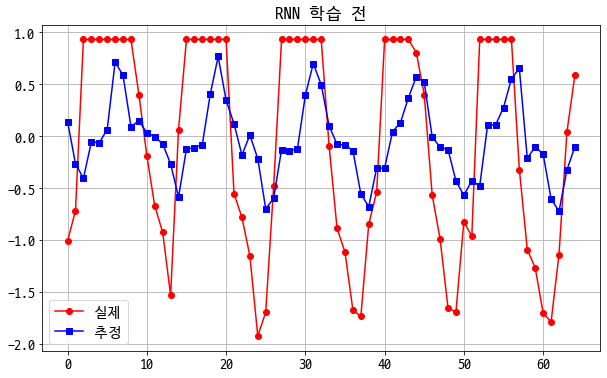

In [21]:
history_RNN = model_RNN.fit(x_train, y_train, epochs=1000, verbose=0)
history_RNN.history['loss'][-1]

0.061857986151097485

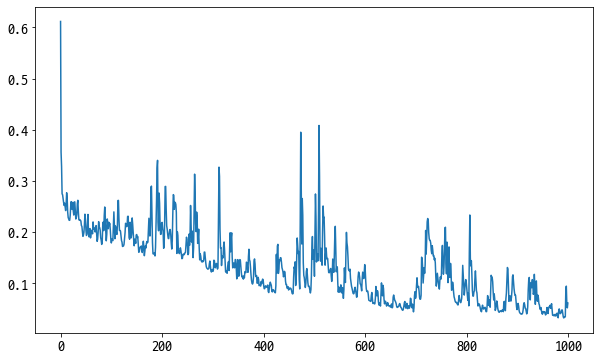

In [24]:
graphs2(history_RNN)

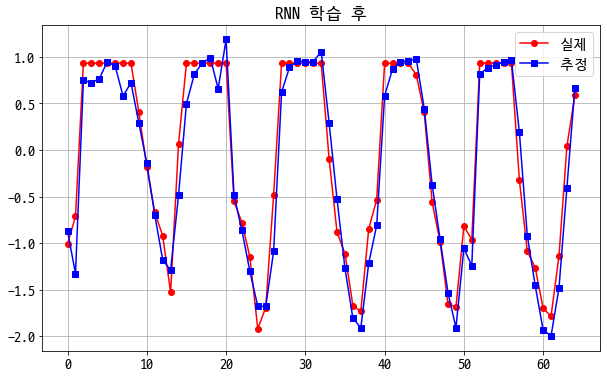

In [26]:
graphs(model_RNN, 'RNN 학습 후')

In [27]:
model_LSTM = model_calls(LSTM, 100)
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


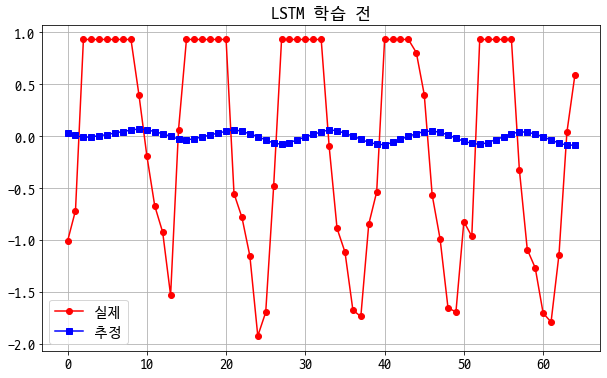

In [28]:
graphs(model_LSTM, 'LSTM 학습 전')

In [30]:
model_LSTM.compile(loss='mse', optimizer='adam')

In [31]:
history_LSTM = model_LSTM.fit(x_train, y_train, epochs=1000, verbose=0)

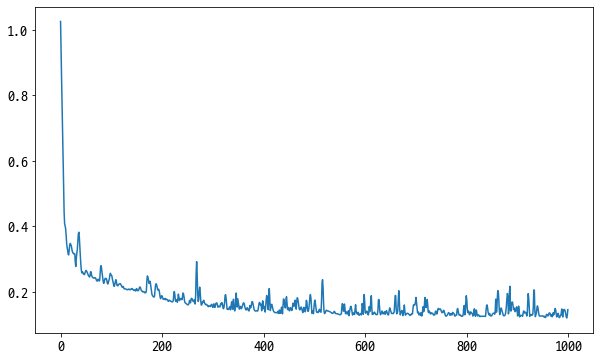

In [32]:
graphs2(history_LSTM)

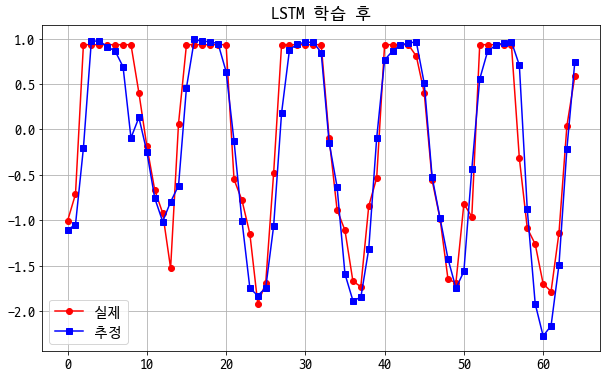

In [33]:
graphs(model_LSTM, 'LSTM 학습 후')